In [1]:
import keras
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras.layers import Input, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape, Lambda
from keras.utils import plot_model
from keras import Model

import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

Using TensorFlow backend.


### Load data

In [3]:
import pandas as pd
numjets = 500000
numvalid = 50000
pixels=40

data_dir = "/data1/users/jcollins/Heidelberg_sample"
hdfstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_images_2.h5")
train_data = hdfstore.select("points",stop=numjets).values
train_data = train_data.reshape(numjets,pixels,pixels,1)

valid_data = hdfstore.select("points",start=numjets,stop=numjets+numvalid).values
valid_data = valid_data.reshape(numvalid,pixels,pixels,1)

### Define CNN-VAE

Architecture from arXiv:1808.08992, with some small changes and variational component added

In [4]:
output_dir = './data/'
experiment_name = 'CNN-AE_bneck-1'

In [6]:
bneck = 1
latent_dim = bneck
image_size = 40 #should be divisible by 4

#Encoder
inputs = Input(shape=(image_size,image_size,1,))
layer = inputs
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same')(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same')(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = Flatten()(layer)
layer = Dense(32,activation='relu')(layer)

#Bottleneck
z = Dense(latent_dim, name='z')(layer)

encoder = Model(inputs, z, name='encoder')
encoder.summary()
#plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

#Decoder
latent_inputs = Input(shape=(latent_dim,), name='latent')

layer = Dense(32,activation='relu')(latent_inputs)
layer = Dense(128*int(image_size*image_size/16),activation='relu')(layer)
layer = Reshape((int(image_size/4),int(image_size/4),128))(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2,2))(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2,2))(layer)
layer = Conv2D(1, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = Reshape((1,image_size*image_size))(layer)
layer = Activation('softmax')(layer)
decoded = Reshape((image_size,image_size,1))(layer)

decoder = Model(latent_inputs, decoded, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


outputs = decoder(encoder(inputs))
ae = Model(inputs, outputs, name='CNN-AE')

ae.compile(loss=keras.losses.mean_absolute_error , optimizer=keras.optimizers.Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
__________

In [ ]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

save_period = 10
epochs = 50

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = ae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=200,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 500000 samples, validate on 50000 samples
Epoch 1/200
500000/500000 [==============================] - 128s 256us/step - loss: 5.3071e-04 - val_loss: 5.0404e-04
Epoch 2/200
500000/500000 [==============================] - 131s 261us/step - loss: 4.8986e-04 - val_loss: 4.7193e-04
Epoch 3/200
500000/500000 [==============================] - 131s 261us/step - loss: 4.6683e-04 - val_loss: 4.5670e-04
Epoch 4/200
500000/500000 [==============================] - 130s 260us/step - loss: 4.5622e-04 - val_loss: 4.5197e-04
Epoch 5/200
500000/500000 [==============================] - 130s 260us/step - loss: 4.4903e-04 - val_loss: 4.4689e-04
Epoch 6/200
500000/500000 [==============================] - 130s 261us/step - loss: 4.4594e-04 - val_loss: 4.4548e-04
Epoch 7/200
500000/500000 [==============================] - 130s 260us/step - loss: 4.4524e-04 - val_loss: 4.4059e-04
Epoch 8/200
500000/500000 [==============================] - 130s 261us/step - loss: 4.4361e-04 - val_loss: 4.4349e-

In [119]:
def chop(array, chop = 1e-5):
    myarray = array
    myarray[array < chop] = 0
    return myarray

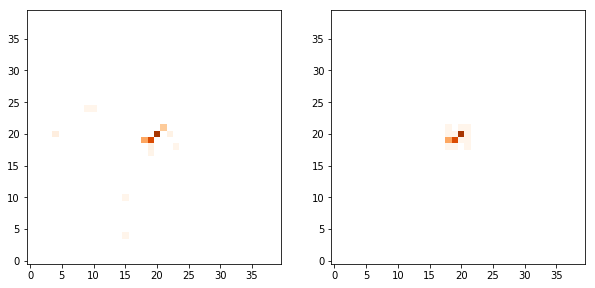

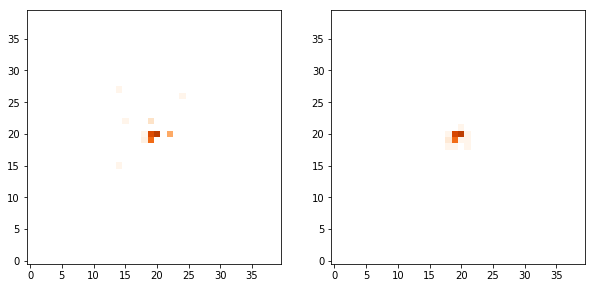

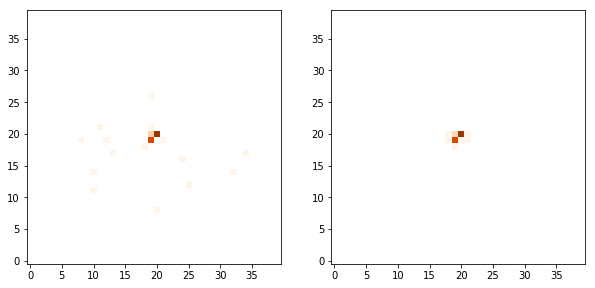

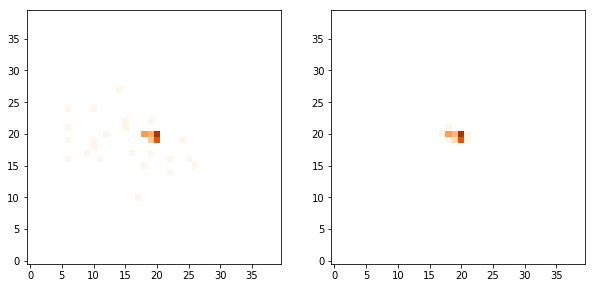

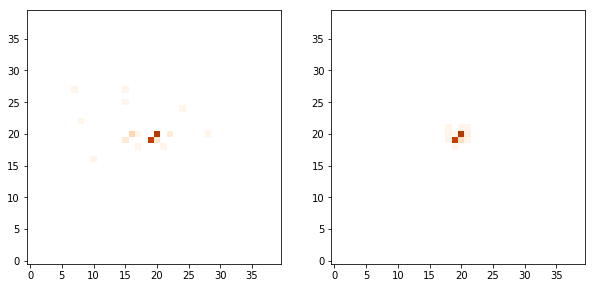

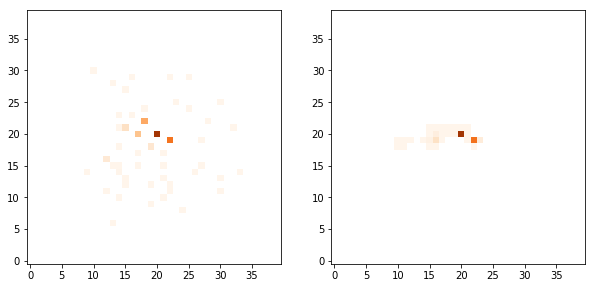

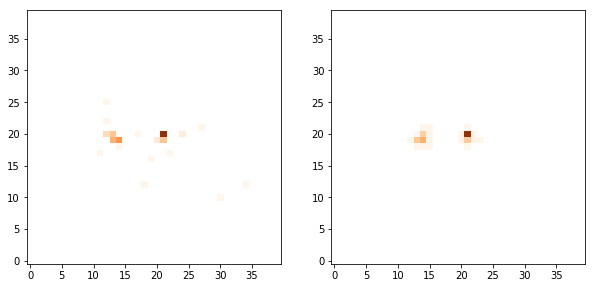

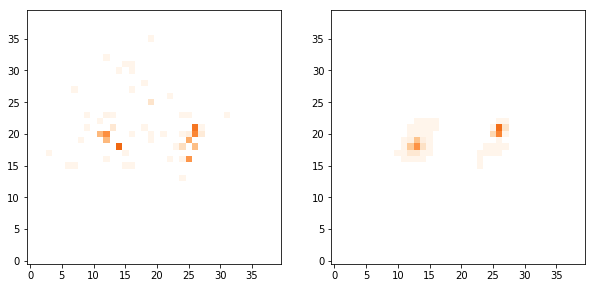

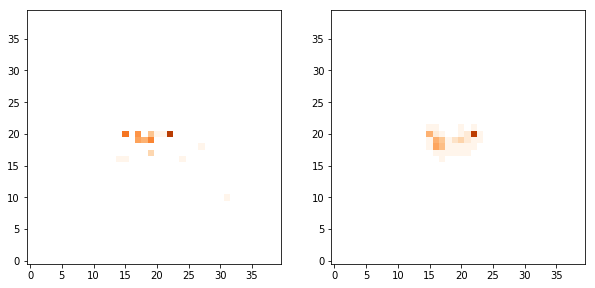

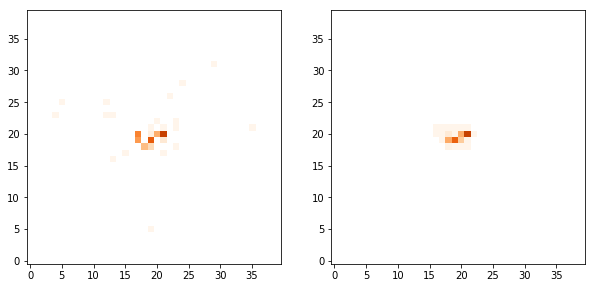

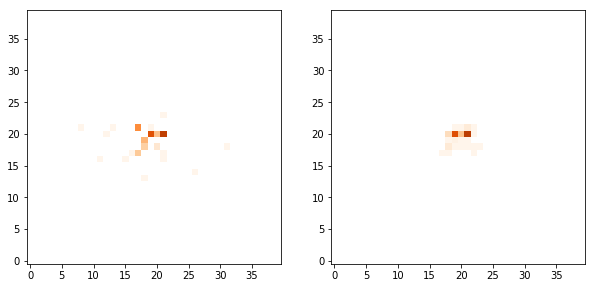

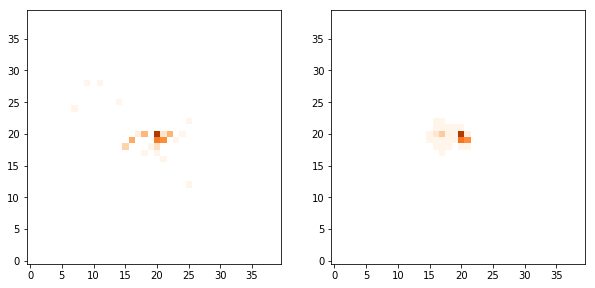

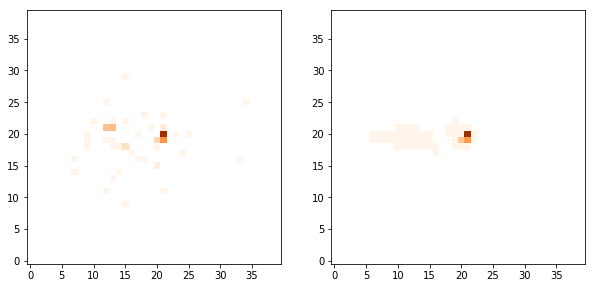

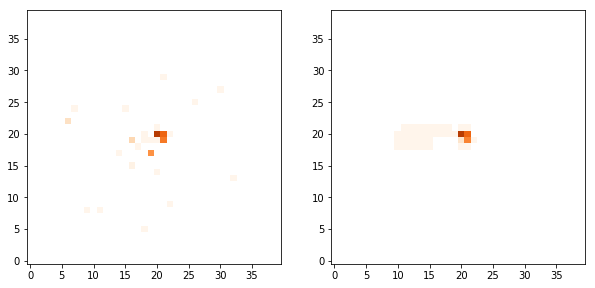

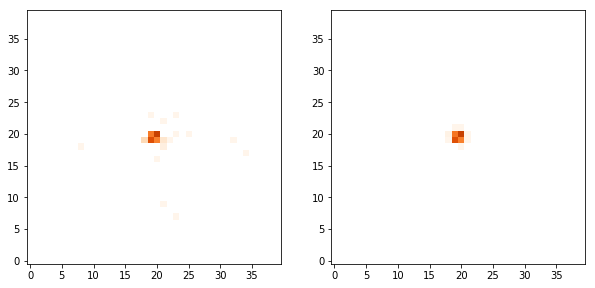

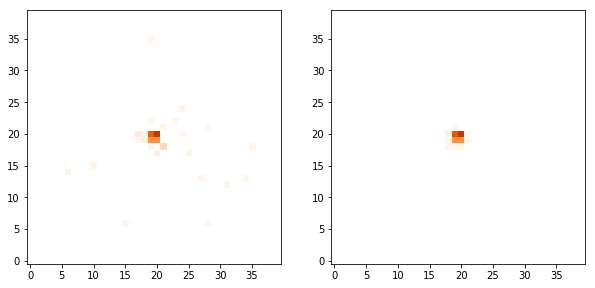

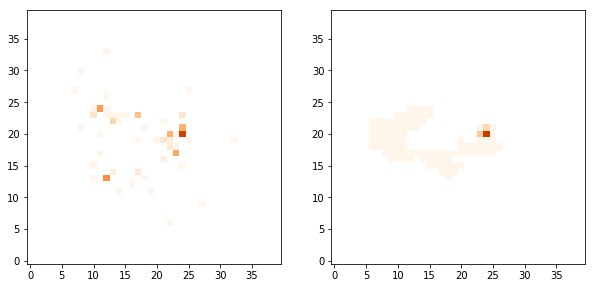

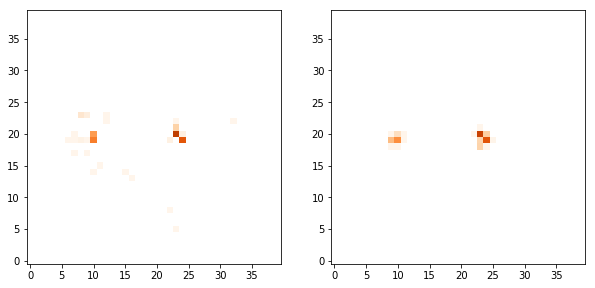

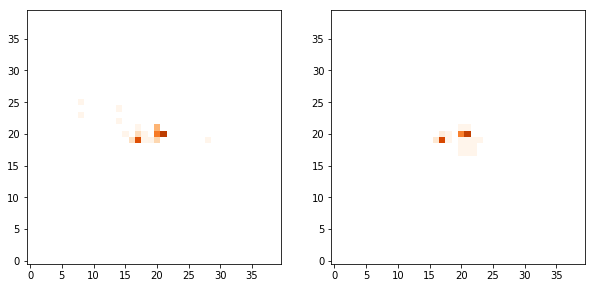

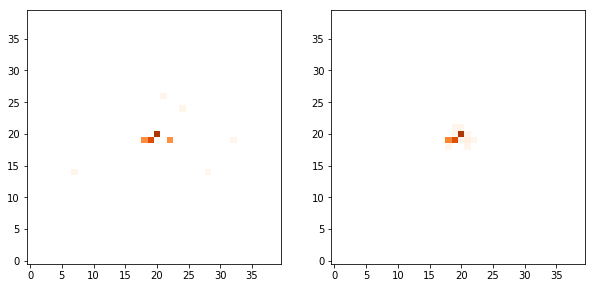

In [125]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

for i in range(20):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    ax[0].imshow(valid_data[i,:,:,0], norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    ax[1].imshow(chop(autoencoder.predict(valid_data[i:i+1])[0,:,:,0],chop=1e-3), norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    plt.show()

In [66]:
data_dir = "/data1/users/jcollins/Heidelberg_sample"
hdfstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_images_top.h5")
# train_data = hdfstore.select("points",stop=numjets).values
# train_data = train_data.reshape(numjets,pixels,pixels,1)

valid_data_top = hdfstore.select("points",start=numjets,stop=numjets+numvalid).values
valid_data_top = valid_data_top.reshape(numvalid,pixels,pixels,1)

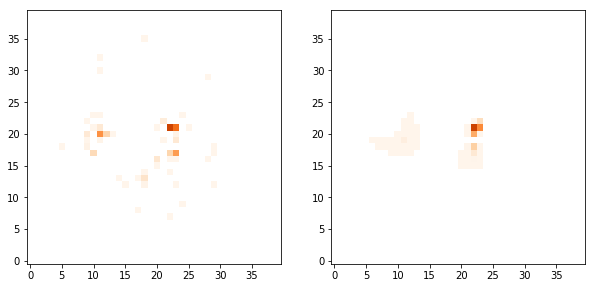

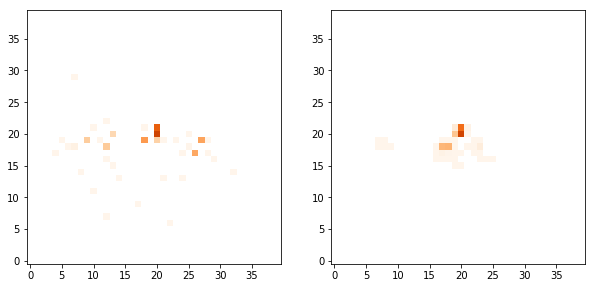

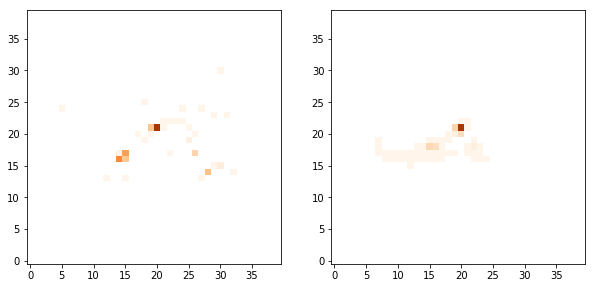

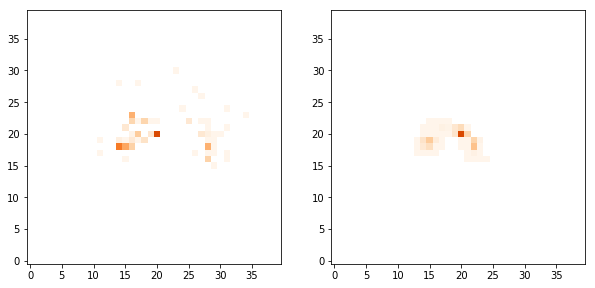

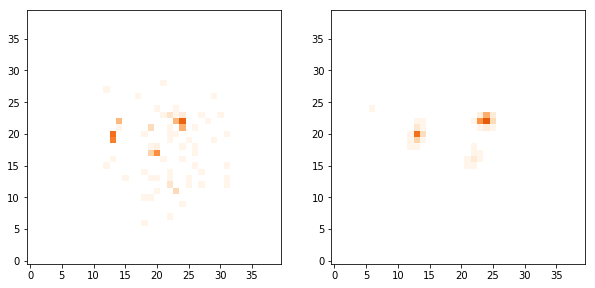

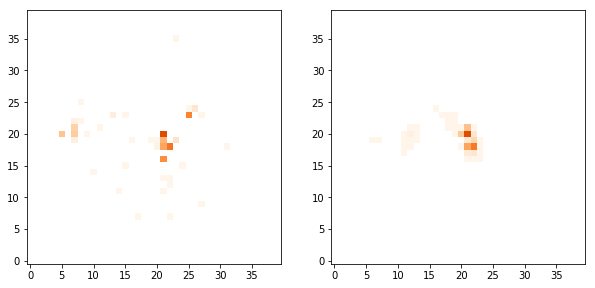

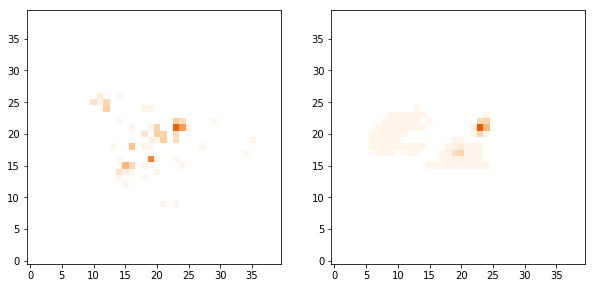

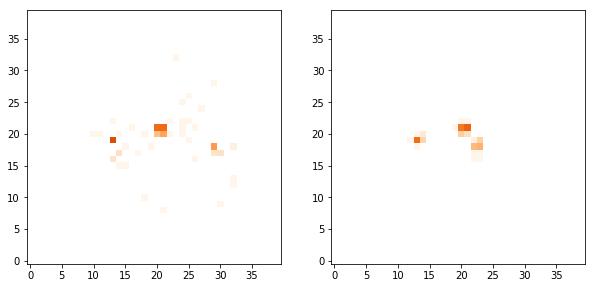

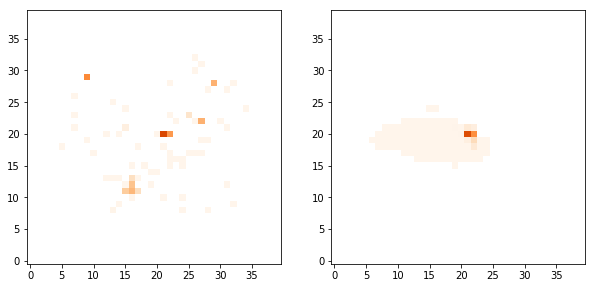

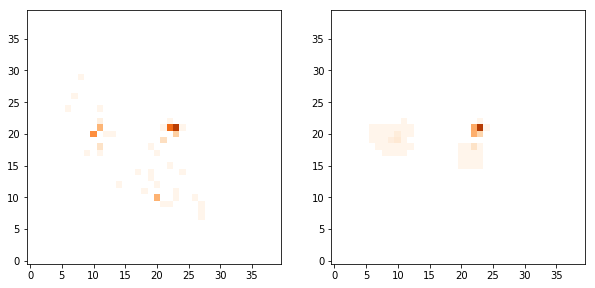

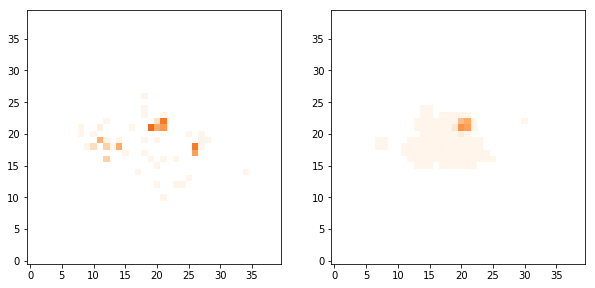

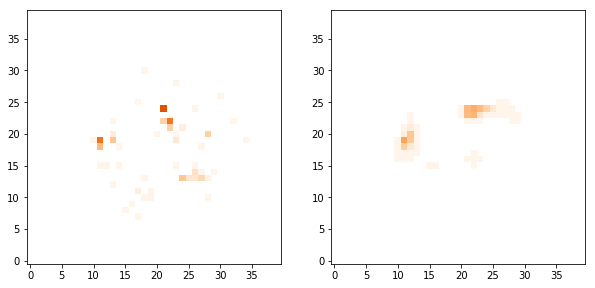

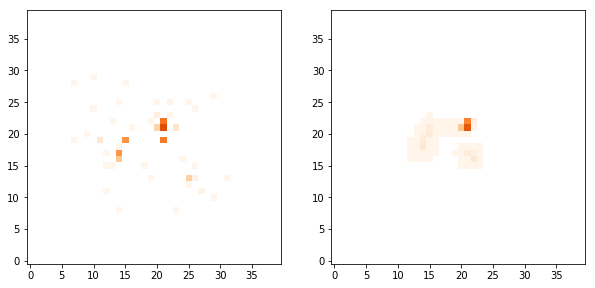

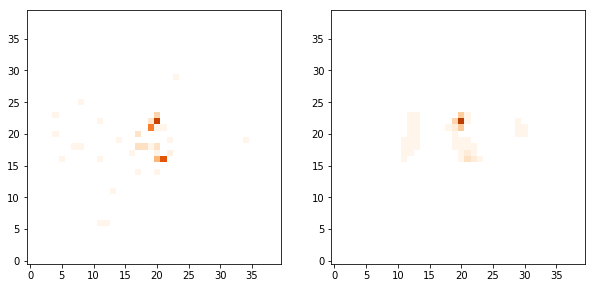

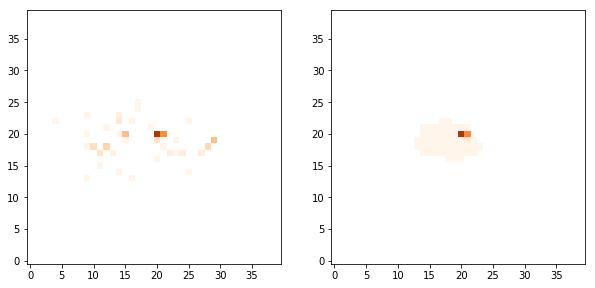

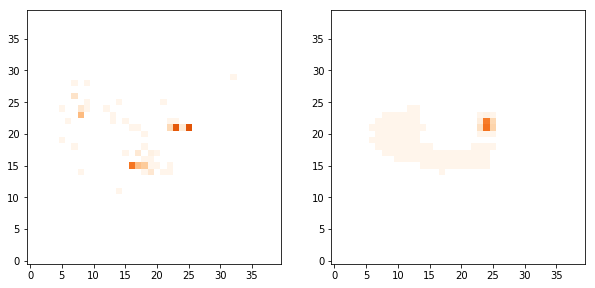

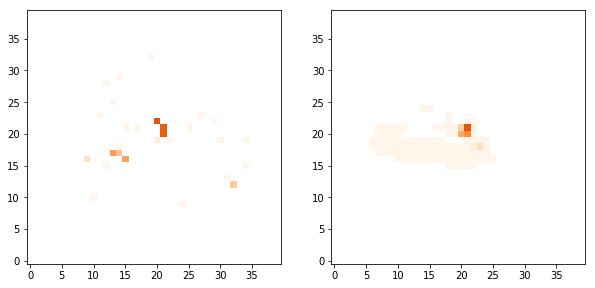

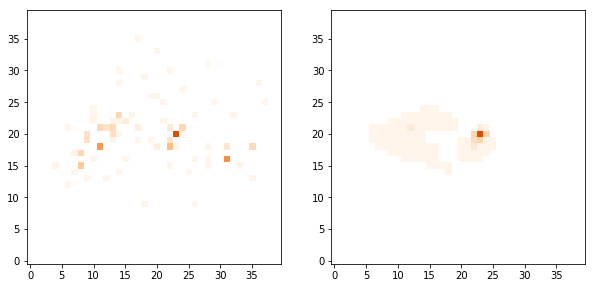

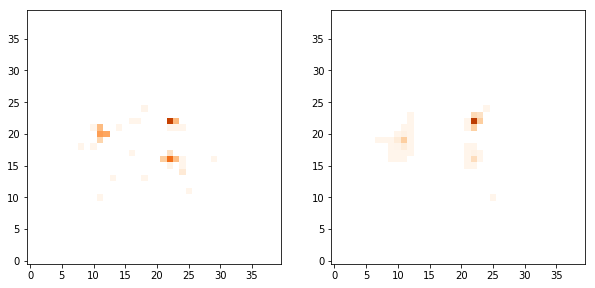

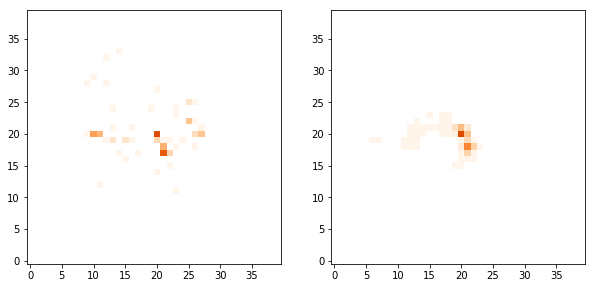

In [70]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

for i in range(20):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    ax[0].imshow(valid_data_top[i,:,:,0], norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    ax[1].imshow(chop(autoencoder.predict(valid_data_top[i:i+1])[0,:,:,0],chop=1e-3), norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    plt.show()